Размер тренировочного датасета: (1168, 78)
Размер тестового датасета: (292, 77)

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import GridSearchCV

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
df = pd.read_csv("train_hw.csv")

Вывод столбцов с более чем 80% пропущенных значений

In [49]:
nan_percent = df.isnull().mean() * 100  # Процент NaN в каждом столбце
high_nan_cols = nan_percent[nan_percent > 80].index.tolist()  # Столбцы с >80% NaN

print("Столбцы с более чем 80% пропущенных значений:")
print(high_nan_cols)

Столбцы с более чем 80% пропущенных значений:
['Alley', 'PoolQC', 'Fence', 'MiscFeature']


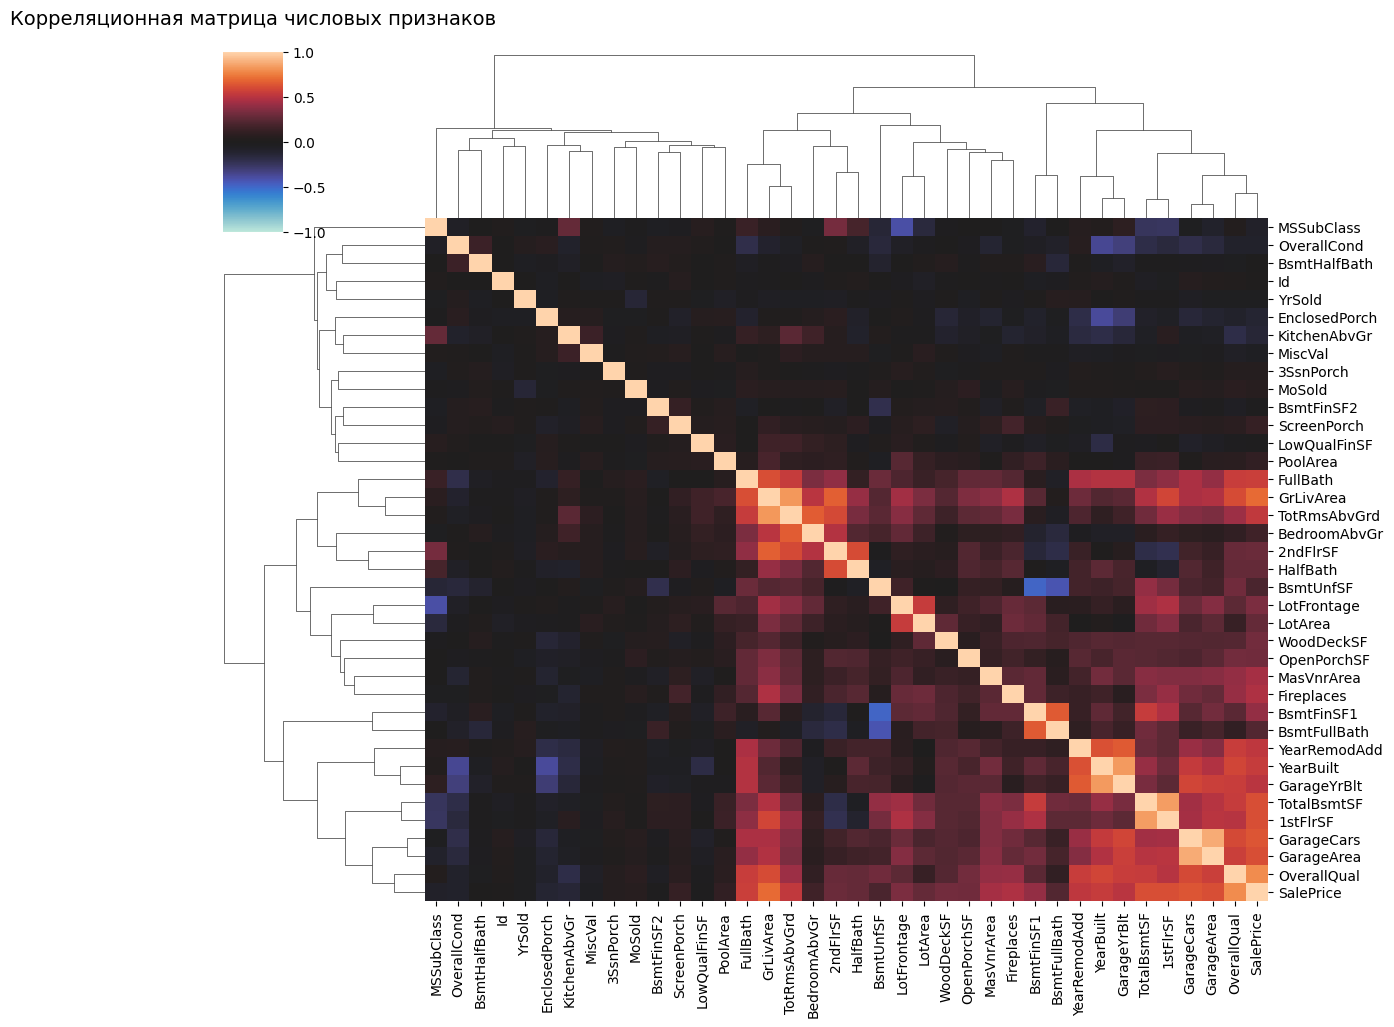

In [50]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_df = df[num_cols]

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        figsize=(12, 10),
        **kwargs,
    )

# Построение корреляционной матрицы
corrplot(num_df, annot=None)

plt.title("Корреляционная матрица числовых признаков", pad=20, fontsize=14)
plt.show()

In [51]:
def load_data(filepath):
    """Загрузка и предварительная обработка данных"""
    data = pd.read_csv(filepath)

    # Удаление 'ненужных' колонок
    # Выбор сделан на основе таблицы корреляций и столбов с большим количеством пропусков.
    cols_to_drop = ['Id', 'Utilities', 'Street', 'Condition2',
                    'RoofMatl', 'Heating', 'PoolQC', 'MiscFeature']
    data = data.drop([c for c in cols_to_drop if c in data.columns], axis=1)

    # Создание новых признаков
    data['AllSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data.get('2ndFlrSF', 0)
    data['AllBath'] = (data['FullBath'] + 0.5 * data.get('HalfBath', 0) + data.get('BsmtFullBath', 0))
    data['Age'] = data['YrSold'] - data['YearBuilt']
    data['YearsSinceRemod'] = data['YrSold'] - data['YearRemodAdd']
    data['OverallQual_TotalSF'] = data['OverallQual'] * data['AllSF']

    if 'SalePrice' in data.columns:
        data['SalePrice'] = data['SalePrice'].clip(lower=0.1)

    return data

In [52]:
def fill_missing_values(df, train_df=None):
    """Заполнение пропущенных значений"""
    df_filled = df.copy()

    # Категориальные признаки
    categorical_cols = df_filled.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df_filled[col] = df_filled[col].fillna('missing')

    # Числовые признаки
    numeric_cols = df_filled.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if train_df is not None:
            # Для тестовых данных используем медианы из тренировочных
            df_filled[col] = df_filled[col].fillna(train_df[col].median())
        else:
            # Для тренировочных данных
            df_filled[col] = df_filled[col].fillna(df_filled[col].median())

    return df_filled

Использование ящиков с усами

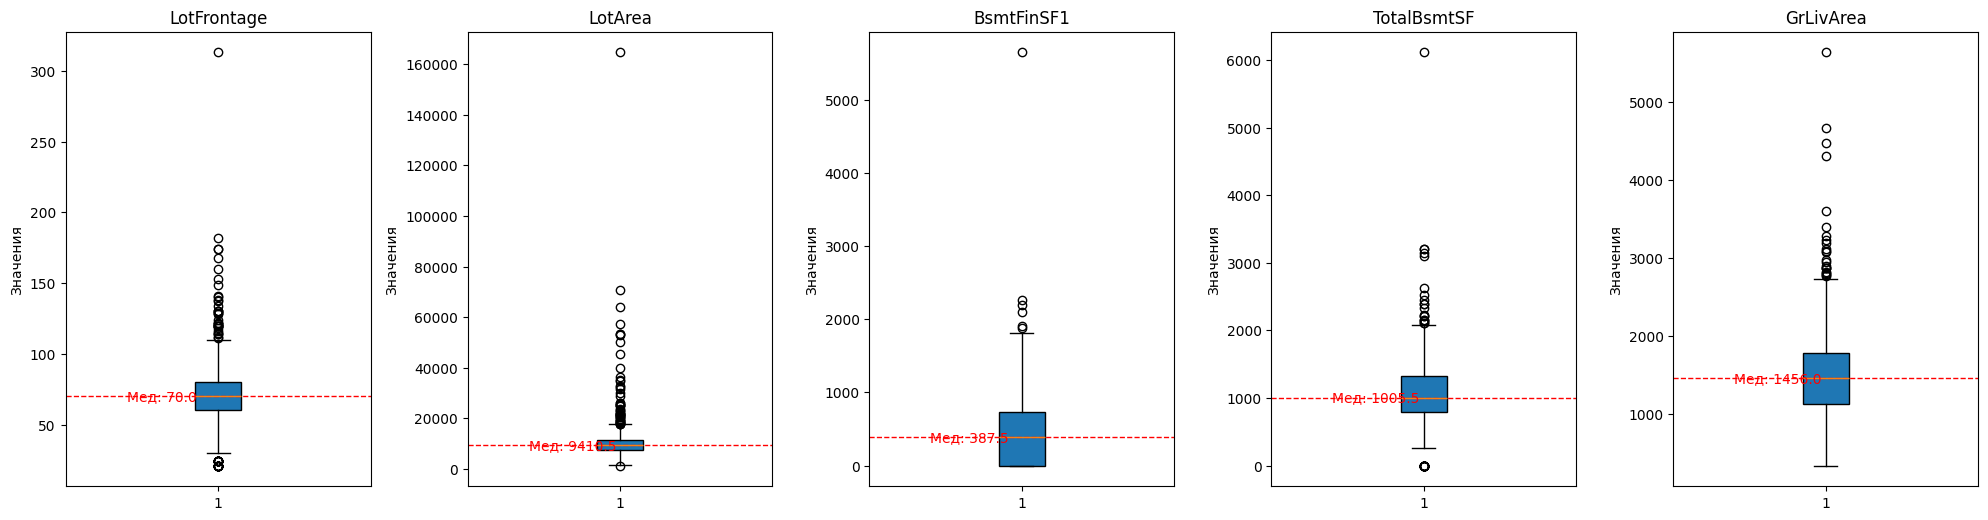

In [53]:
columns_to_plot = [
    'LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea'
]

# Создаем подграфики (subplots) для каждого признака
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(24, 10))  # 2 строки, 6 столбцов

# Строим Box Plot для каждого столбца
for i, col in enumerate(columns_to_plot):
    row = i // 6
    col_num = i % 6
    axes[row, col_num].boxplot(df[col].dropna(), vert=True, patch_artist=True)
    axes[row, col_num].set_title(col)
    axes[row, col_num].set_ylabel('Значения')

    # Добавляем горизонтальную линию для медианы
    median = df[col].median()
    axes[row, col_num].axhline(y=median, color='r', linestyle='--', linewidth=1)
    axes[row, col_num].text(0.7, median, f'Мед: {median:.1f}',
                            color='r', va='center', ha='left')

# Удаляем пустые subplots, если столбцов не хватает
for i in range(len(columns_to_plot), 12):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [54]:
   def remove_outliers(df):
    """Удаление выбросов"""
    df_clean = df.copy()
    df_clean = df_clean[df_clean['LotFrontage'] < 200]
    df_clean = df_clean[df_clean['GrLivArea'] < 4500]
    df_clean = df_clean[df_clean['TotalBsmtSF'] < 4000]
    df_clean = df_clean[df_clean['LotArea'] < 80000]
    df_clean = df_clean[df_clean['BsmtFinSF1'] < 3000]
    return df_clean

   Было выявлено, что удаление выбросов категорий LotFrontage и BsmtFinSF1 не влияют на результат

In [55]:
def create_submission(model, test_path='test_hw.csv', output_path='submission.csv'):
    """Создание файла для отправки"""
    test_data = load_data(test_path)
    test_data = fill_missing_values(test_data, train_data)

    # Предсказание
    preds = model.predict(test_data)
    preds = np.clip(preds, 0.1, None)  # Гарантируем положительные значения

    submission = pd.DataFrame({
        'Id': pd.read_csv(test_path)['Id'],
        'SalePrice': preds
    })
    submission.to_csv(output_path, index=False)
    print(f"Файл сохранен: {output_path}")
    print("Пример предсказаний:")
    print(submission.head())

-Делим данные из train_hw.csv на две части: обучающую и валидационную для избежания переобучения модели.

-Для преобразования категориальных признаков в числовой формат используется One-Hot Encoding.

In [58]:
if __name__ == "__main__":
    # Загрузка данных
    train_data = load_data('train_hw.csv')

    # Заполнение пропусков
    train_data = fill_missing_values(train_data)

    # Удаление выбросов
    train_data = remove_outliers(train_data)

    print(f"Размер тренировочного датасета: {train_data.shape}")
    # Разделение данных на обучающую и валидационную выборки (80%/20%)
    X = train_data.drop('SalePrice', axis=1)
    y = train_data['SalePrice']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Создание пайплайна предобработки
    numeric_features = X.select_dtypes(include=['number']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    # Создание и обучение модели Lasso с подбором параметров
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(random_state=42))
    ])

    # Параметры для подбора
    param_grid = {
        'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    }

    # Поиск по сетке с кросс-валидацией
    grid_search = GridSearchCV(model, param_grid, cv=5,
                             scoring=make_scorer(mean_squared_log_error, greater_is_better=False))

    print("Подбираем лучшие параметры для Lasso...")
    grid_search.fit(X_train, y_train)

    # Лучшая модель
    best_model = grid_search.best_estimator_

    print(f"\nЛучший параметр alpha: {grid_search.best_params_['regressor__alpha']}")
    print(f"Лучший MSLE: {-grid_search.best_score_:.5f}")

    # Оценка на обучающей выборке (80% данных)
    train_preds = best_model.predict(X_train)
    train_msle = mean_squared_log_error(y_train, train_preds)
    print(f"\nTrain MSLE (80% данных): {train_msle:.5f}")

    # Оценка на валидационной выборке (20% данных)
    val_preds = best_model.predict(X_val)
    val_msle = mean_squared_log_error(y_val, val_preds)
    print(f"Validation MSLE (20% данных): {val_msle:.5f}")


    # Финальное обучение на всех данных и создание submission
    best_model.fit(X, y)  # Переобучаем на всех данных
    create_submission(best_model)

Размер тренировочного датасета: (1165, 78)
Подбираем лучшие параметры для Lasso...


C:\Users\User\Desktop\Model\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.808e+10, tolerance: 4.381e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\Desktop\Model\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.641e+10, tolerance: 3.821e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\Desktop\Model\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali


Лучший параметр alpha: 100
Лучший MSLE: 0.01571

Train MSLE (80% данных): 0.01218
Validation MSLE (20% данных): 0.01381
Файл сохранен: submission.csv
Пример предсказаний:
   Id      SalePrice
0   1  125990.711630
1   2  186507.488633
2   3  192863.620071
3   4  197010.433908
4   5  165940.813280


C:\Users\User\Desktop\Model\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.617e+09, tolerance: 7.468e+08
  model = cd_fast.enet_coordinate_descent(


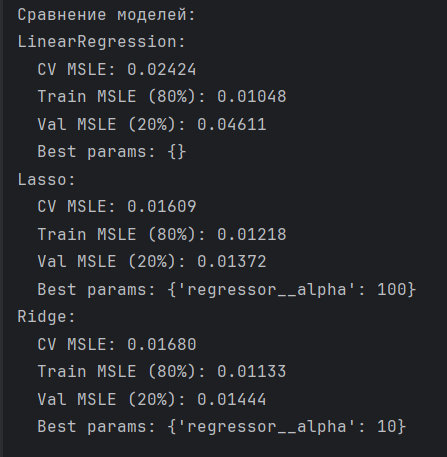

-Регуляризованные модели (Lasso и Ridge) показали значительно лучшие результаты по сравнению с обычной линейной регрессией, что подтверждает важность регуляризации для данной задачи.

-Lasso немного превзошел Ridge по всем метрикам, что может указывать на наличие незначимых признаков, которые Lasso эффективно обнуляет.

Вывод: выбранная модель Lasso демонстрирует стабильную работу и хорошую обобщающую способность, что делает ее подходящим выбором для данной задачи.